In [56]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import pygsheets
import pandas as pd
import load_data
sys.path.append('modeling')
import exponential_modeling

outcomes = ['new_cases_yesterday', 'new_deaths_yesterday']
df_hospital = load_data.load_hospital_level()
df_county = load_data.load_county_level()
df_county = df_county.sort_values(load_data.outcome_deaths, ascending=False)
df = df_hospital.merge(df_county, how='left', on='countyFIPS')
df[outcomes] = df[outcomes].fillna(0)
# note this many hospitals couldn't be matched to a county - we don't know how to include them!
print('# unmatched hospitals:', df['countyFIPS'].isna().sum())
print('# matched hospitals:', (~df['countyFIPS'].isna()).sum())
print('# academic matched hospitals:', (~df['countyFIPS'].isna() & df['IsAcademicHospital']).sum())
print('# academic matched hospitals w/ ICU beds:', (~df['countyFIPS'].isna() & 
                                                    df['IsAcademicHospital'] &
                                                    df['ICU Beds'] > 0).sum())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
# unmatched hospitals: 598
# matched hospitals: 6545
# academic matched hospitals: 1215
# academic matched hospitals w/ ICU beds: 1087


- we filter by academic hospitals since they seem to have enough personnel to deal with extra ventilators
- we also filter to only include hospitals w/ ICU beds
- unfortunately we don't look into FQHCs, as they may not be the place to receive urgent ventilator care

In [57]:
# rename keys
remap = {
    '#ICU_beds': 'ICU Beds in County',
    'County Name_x': 'County Name',
    'Facility Name_x': 'Facility Name',
    'new_deaths_yesterday': 'New Deaths',
    'new_cases_yesterday': 'New Cases',
}
df = df.rename(columns=remap)

# filter hospitals
df = df[~df['countyFIPS'].isna() & df['IsAcademicHospital'] & df['ICU Beds'] > 0]
df = df.sort_values(by=[load_data.outcome_deaths, 'ICU Beds'], ascending=False)
# df = df.rename(columns={'#ICU_beds': '#ICU_beds_county_level'})
df['Frac ICU Beds of County'] = df['ICU Beds'] / df['ICU Beds in County']

# get predicted #deaths
# df = exponential_modeling.estimate_deaths(df)
df['Vent Demand'] = df['New Deaths'] * 5 * df['Frac ICU Beds of County']
df['Vent Supply'] = df['ICU Beds']
df['Vent Needed'] = df['Vent Demand'] - df['Vent Supply']
df['Vent Needed'] = df['Vent Needed'].apply(lambda x: max(0, x)).astype(int)

In [58]:
# make smaller df
outcome_keys = ['New Cases', 'New Deaths']
vent_keys = ['Vent Needed', 'Vent Demand', 'Vent Supply']
county_info_keys = ['County Name']
county_meta_keys = ['ICU Beds in County', 'City', 'countyFIPS']
hospital_keys = ['Facility Name']
hospital_contact_keys = ['Website',  'Phone Number']
hospital_meta_keys = ['ICU Beds', 'Total Beds', 'Total Employees', 'Hospital Type',
                      'Frac ICU Beds of County', 'Mortality national comparison', 
                      'TIN', 'Urban or Rural Designation']

# d contains all these keys
d = df[outcome_keys + vent_keys + county_info_keys + county_meta_keys + \
       hospital_keys + hospital_contact_keys + hospital_meta_keys].round(2)

# things to output
d_vent = d[vent_keys + hospital_keys + county_info_keys]
contact_df_keys = hospital_keys + county_info_keys + county_meta_keys + ['TIN'] + hospital_contact_keys
d_contact = d[contact_df_keys]
d_full = d

TypeError: can only concatenate list (not "str") to list

**look at most affected hospitals**

In [51]:
# d.groupby('countyFIPS').head(1).head(8) # look at top counties

# export to google sheets

- requires a creds.json file in the root directory
- need to make a sheet and share it with `chandan@r4l-predictions.iam.gserviceaccount.com`
- full hospitals spreadsheet: https://docs.google.com/spreadsheets/d/1ZLev2pRIPXvP-qNnvAtO53-bCrAGTAhB_w0w7bZKAWw/edit#gid=0

In [52]:
gc = pygsheets.authorize(service_file='creds.json')

#open the google spreadsheet (where 'PY to Gsheet Test' is the name of my sheet)
sheet_name = 'Ventilator Demand Prediction'
sh = gc.open(sheet_name) # name of the hospital

wks = sh[0] #select a sheet
wks.set_dataframe(d_vent, (1,1)) #update the first sheet with df, starting at cell B2. 

wks = sh[1]
wks.set_dataframe(d_contact,(1,1))

wks = sh[2]
wks.set_dataframe(d_full,(1,1))

# useful county-level plots

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



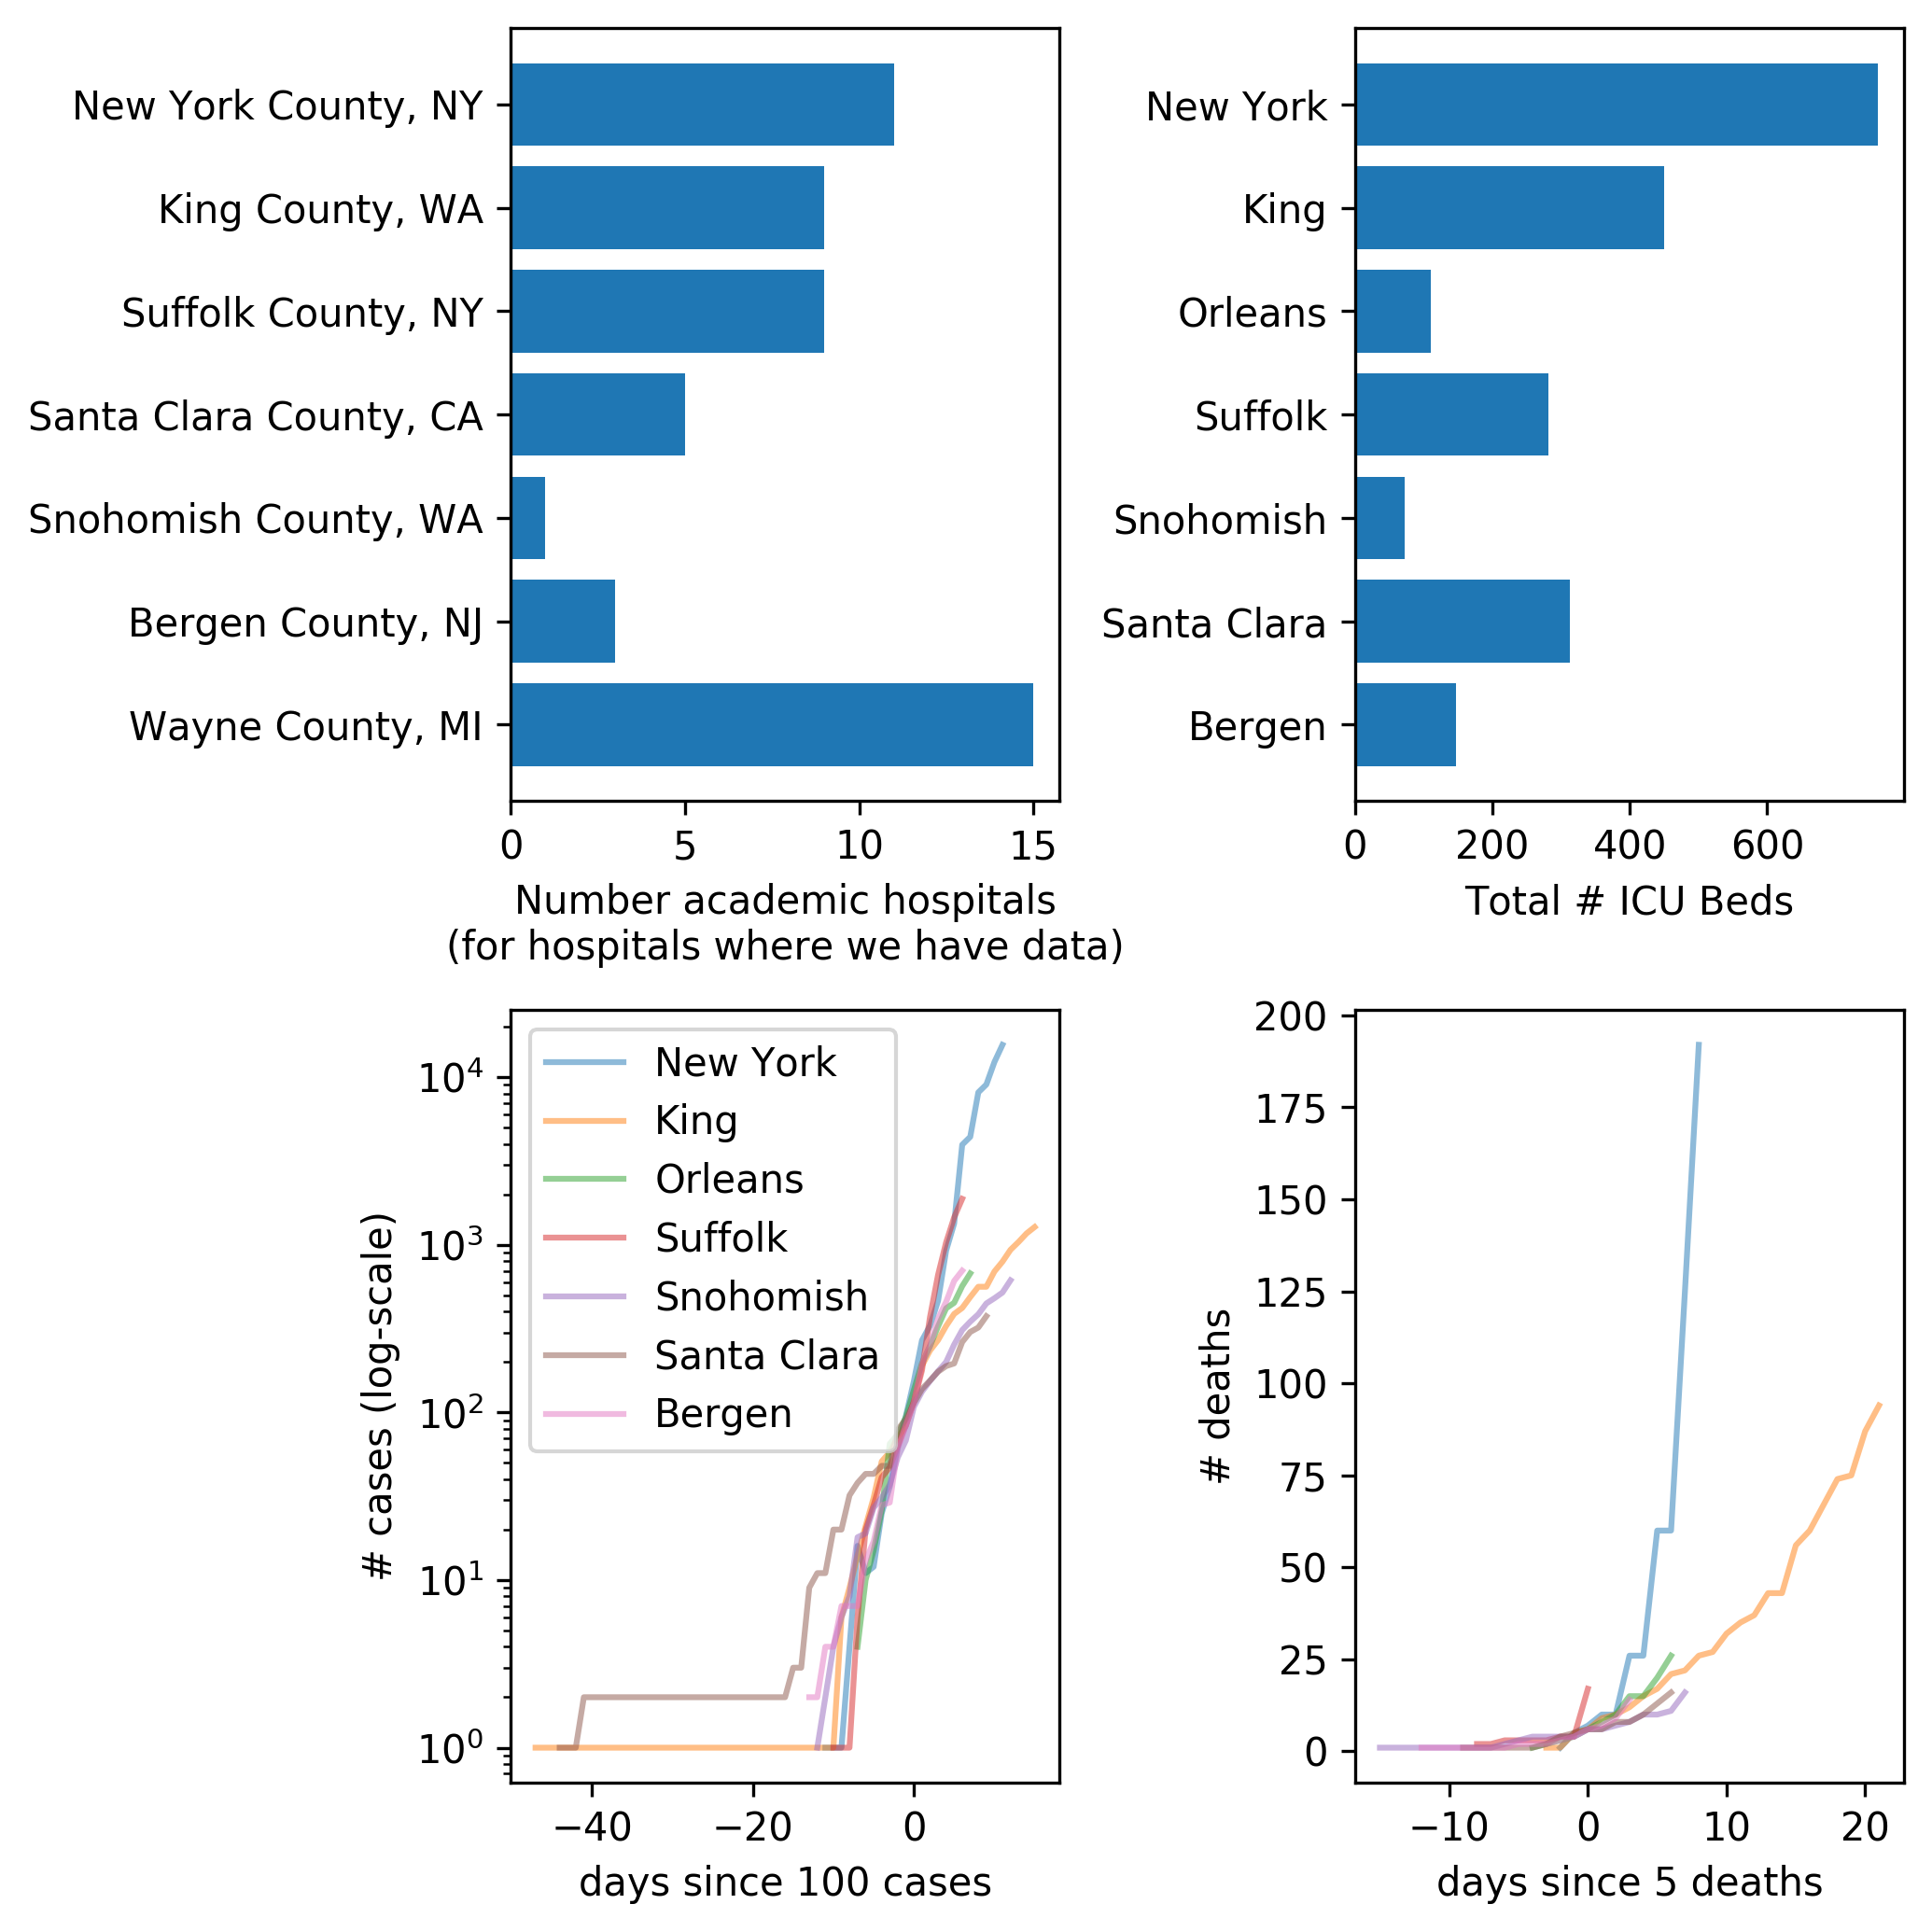

In [53]:
R, C = 2, 2
NUM_COUNTIES = 7
plt.figure(dpi=300, figsize=(7, 7))


plt.subplot(R, C, 1)
c = 'County Name'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
# d = df[outcome_keys + hospital_keys]
# d = d.sort_values('New Deaths', ascending=False)
for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals\n(for hospitals where we have data)')

plt.subplot(R, C, 2)
plt.barh(df_county.CountyName[:NUM_COUNTIES].values[::-1], df_county['#ICU_beds'][:NUM_COUNTIES][::-1]) # reverse to plot top down
plt.xlabel('Total # ICU Beds')

r = df_county
for i in range(NUM_COUNTIES):
    row = df_county.iloc[i]
    deaths = np.array([x for x in row['deaths'] if x > 0])
    cases = np.array([x for x in row['cases'] if x > 0])
    
    CASES_ALIGNMENT = 100
    idx_align = np.where(cases > CASES_ALIGNMENT)[0][0]
    n = cases.size
    
    DEATHS_ALIGNMENT = 5
    idx_align_deaths = np.where(deaths > DEATHS_ALIGNMENT)[0][0]
    n2 = deaths.size

    
    plt.subplot(R, C, 3)
    plt.plot(np.arange(n) - idx_align, cases, alpha=0.5, label=row['CountyName'])
    plt.yscale('log')
    plt.ylabel('# cases (log-scale)')
    plt.xlabel(f'days since {CASES_ALIGNMENT} cases')
    plt.legend()
    
    plt.subplot(R, C, 4)
    plt.plot(np.arange(n2) - idx_align_deaths, deaths, alpha=0.5)
    plt.ylabel('# deaths')
    plt.xlabel(f'days since {DEATHS_ALIGNMENT} deaths')
plt.tight_layout()
plt.show()

# intra-county plots

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



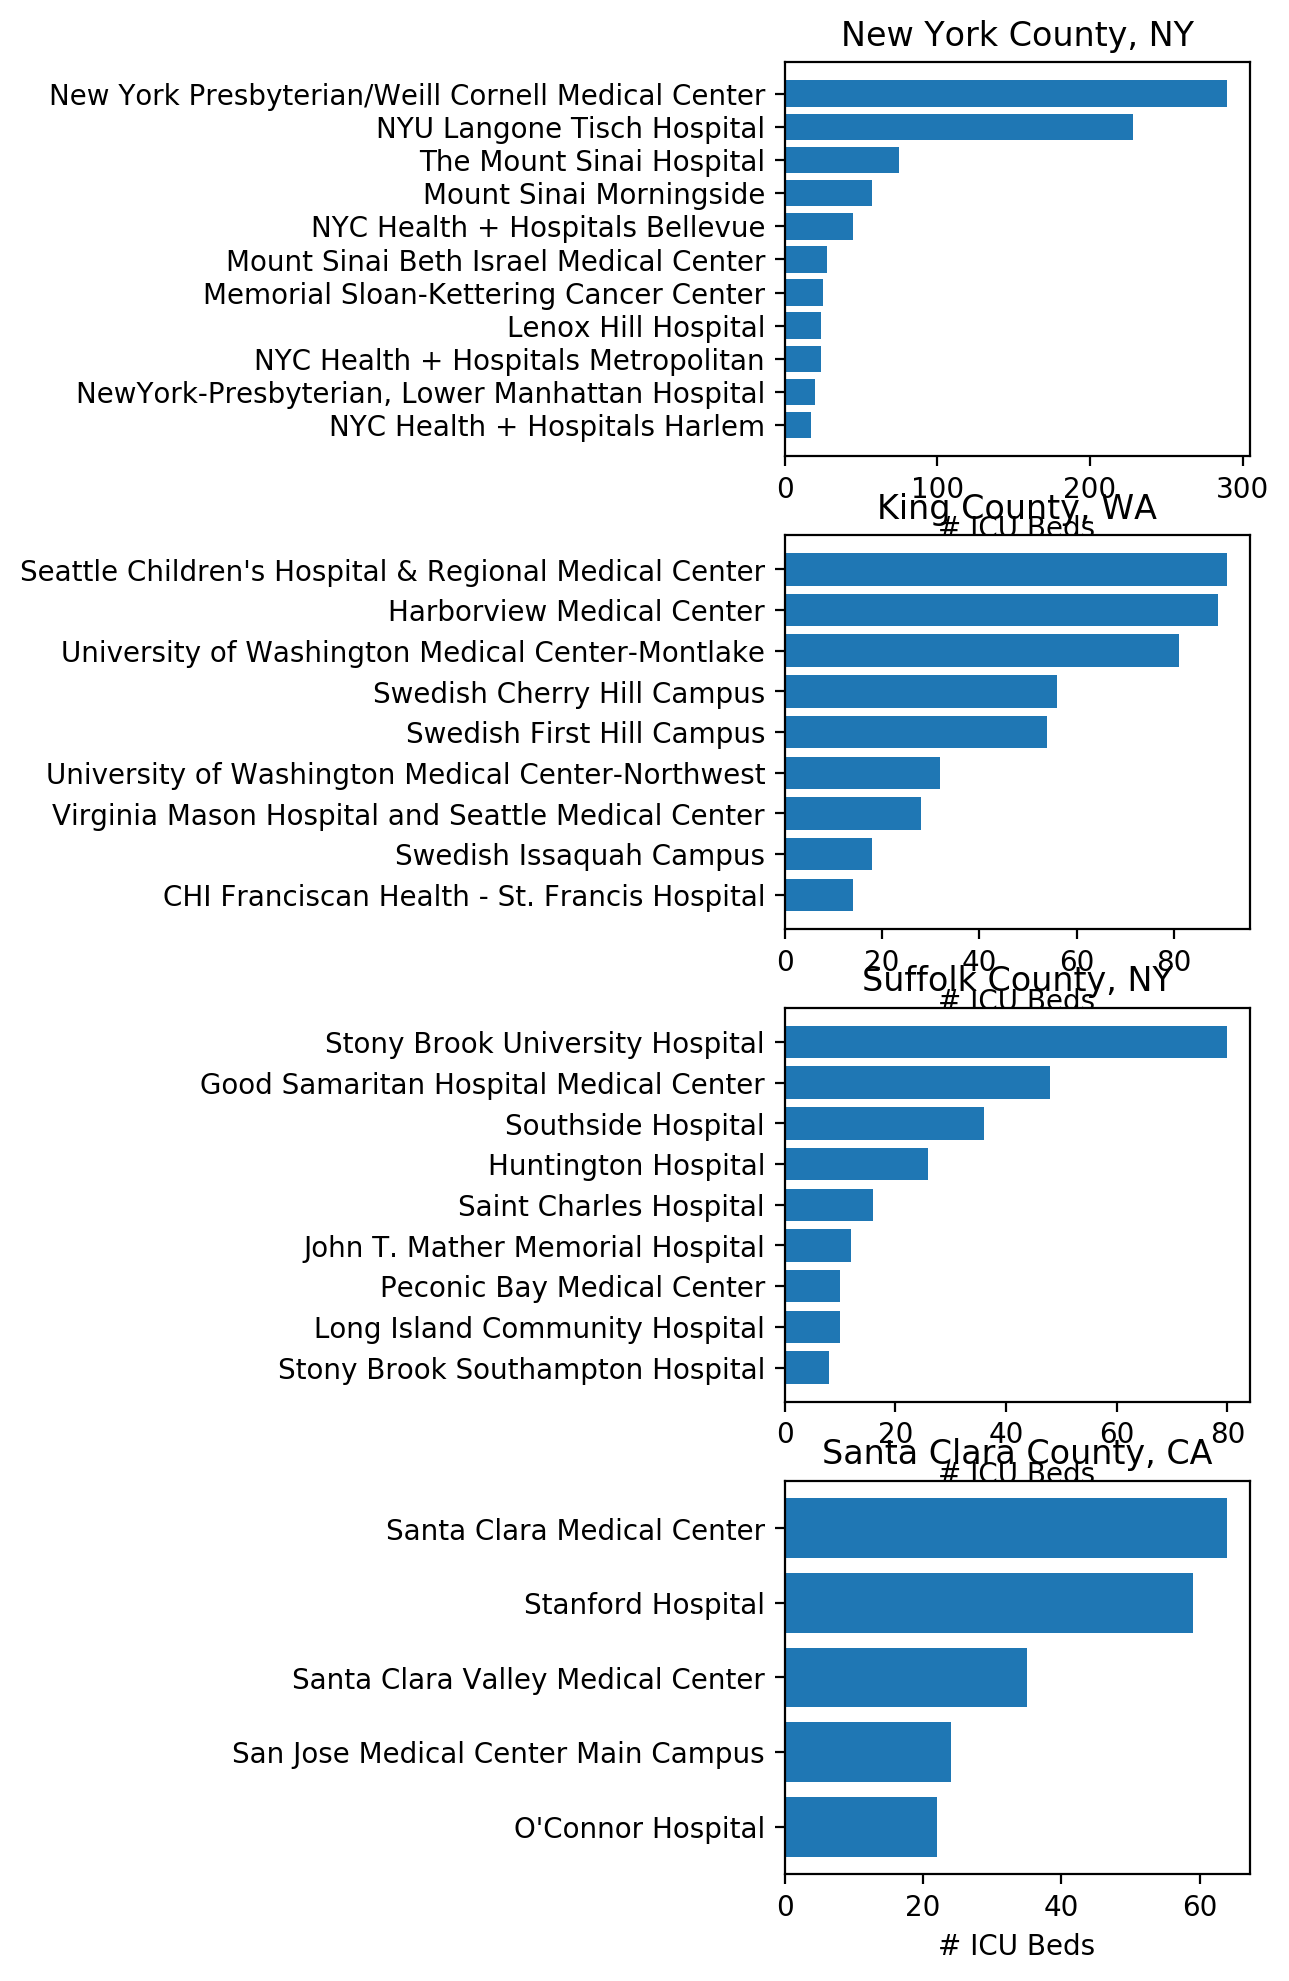

In [54]:
county_names = d[c].unique()[:NUM_COUNTIES]
R, C = 4, 1
plt.figure(figsize=(C * 3, R * 3), dpi=200)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    cn = county_names[i]
    dc = d[d[c] == cn]
    plt.barh(dc['Facility Name'][::-1], dc['ICU Beds'][::-1])
    plt.title(cn)
    plt.xlabel('# ICU Beds')
plt.tight_layout()
# plt.subplots_adjust(bottom=1)
plt.show()